# Notebook configuration

In [14]:
import glob

run_number = 4495#"MC/Kr"
map_run_number = 4446
outputfolder = "/Users/ansimez/Documents/InvCit/hdf5/{}/reset_dst/".format(run_number)
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps/pmaps*.root.h5".format(run_number))
#inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/irene/*h5".format(run_number))
#outputfile = outputfolder + "sipm_dst_PMT_{}.h5".format(run_number)
#outputfile = outputfolder + "sipm_dst_PMT.h5"
#outputfile = outputfolder + "sipm_longDiff_{}.h5".format(run_number)

#pmtcorr = "/Users/ansimez/Documents/InvCit/ICARO/icaro/NB_Ander/PMT_Map_corr_keV"
#sipmcorr = "/Users/ansimez/Documents/InvCit/ICARO/icaro/NB_Ander/SiPM_Map_corr_v2z"


In [15]:
inputfiles

['/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.000_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.001_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.002_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.003_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.004_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.005_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.006_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.007_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.008_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.009_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.010_4495.root.h5',
 '/Users/ansimez/Documents/InvCit/hdf5/4495/pmaps/pmaps.gdcsnext.011_4495.ro

# Dorothea cut analysis

In [16]:
import os
import functools
import itertools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.database.load_db as dbf
import invisible_cities.filters.s1s2_filter as s1s2filt
import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.reco.pmaps_functions_c  as pmapsfc
import invisible_cities.reco.corrections    as corrf
import invisible_cities.core.core_functions as coref
import invisible_cities.core.core_functions_c as corefc
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.reco.reset_functions as rstf
#import invisible_cities.reco.reset_functions_old as rstfOld
import invisible_cities.io.table_io as tbiof
import invisible_cities.io.pmap_io as pmapio
import invisible_cities.io.dst_io as dstio
import invisible_cities.reco.xy_algorithms as xyf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import gausstext

from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.core.system_of_units import pes, mm, mus, ns

from invisible_cities.evm.pmaps import S2, S2Si, Peak

Running on  Thu Nov  2 14:53:10 2017


#### General plotting options

In [17]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

#### Load SiPM info

In [18]:
DataSiPM = dbf.DataSiPM(run_number)
DataPMT = dbf.DataPMT(run_number)

#### General plots

In [19]:
def plot_var(s2ec, s2ea, x, y, r, z, sipmC, nsipm):    

    hist(s2ec, 100, [np.min(s2ec), np.max(s2ec)], weights = 1/nsipm);
    labels("pes", "Entries", "S2 cathode energy")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])

    hist(s2ea, 100, [np.min(s2ea), np.max(s2ea)], weights = 1/nsipm);
    labels("pes", "Entries", "S2 anode energy")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])
    
    hist(x, 100 , [-200., 200.], weights = 1/nsipm)
    labels("X (mm)", "Entries", "X distribution")
    
    hist(y, 100 , [-200., 200.], weights = 1/nsipm)
    labels("Y (mm)", "Entries", "Y distribution")
    
    hist(z, 600, [0., 600.], weights = 1/nsipm)
    labels("Z (mm)", "Entries", "Z distribution")
    
    hist(r, 200, [0., 200.], weights = 1/nsipm)
    labels("R (mm)", "Entries", "R distribution")
    
    hist(sipmC, 200, [np.min(sipmC),np.max(sipmC)])
    labels("SiPM charge (pes)", "Entries", "SiPM Charge distribution")
    
    hist2d(x, y, 50, [[-200., 200.],[-200.,200.]], weights = 1/nsipm)
    labels("X (mm)", "Y (mm)", "XY distribution")
    #### General plots
    hist2d(r, s2ec, 50, [[0.,200.], [np.min(s2ec), np.max(s2ec)]], weights = 1/nsipm)
    labels("R (mm)", "Cathode energy", "S2 Cathode vs R")
    
    hist2d(r, s2ea, 50, [[0.,200.], [np.min(s2ea), np.max(s2ea)]], weights = 1/nsipm)
    labels("R (mm)", "Anode energy", "S2 Anode vs R")
    
    hist2d(z, s2ec, 50, [[0.,600.], [np.min(s2ec), np.max(s2ec)]], weights = 1/nsipm)
    labels("Z (mm)", "Cathode energy", "S2 Cathode vs Z")
    
    hist2d(z, s2ea, 50, [[0.,600.], [np.min(s2ea), np.max(s2ea)]], weights = 1/nsipm)
    labels("Z (mm)", "Anode energy", "S2 Anode vs Z")

In [20]:
def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure(figsize=(20,8))

    plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))

    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))

#### Function to calculate lifetime

In [21]:
def lifetime_calculation(z, zrange, energy, erange):
    hist(energy, 50, erange)
    labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")

    low_cut   = 11000 * np.exp(-0.0009*z)
    high_cut  = 14000 * np.exp(-0.0009*z)
    sel       = coref.in_range(energy, low_cut, high_cut) # remove low and high E background

    hist2d(z, energy, (100, 50), range=(zrange, erange))
    x, y, u_y = fitf.profileX(z[sel], energy[sel], 100, xrange=zrange, yrange=erange)

    plt.plot(x, y, profOpt)
    plt.plot(z,  low_cut, "k.")
    plt.plot(z, high_cut, "k.")

    Zrange_LT = 50, 350
    
    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    plt.plot(x, f.fn(x), fitOpt)
    print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    print("Chi2          = {:.2f}          ".format(f.chi2))

    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")

    return corrf.LifetimeCorrection(-f.values[1], f.errors[1])

In [22]:
class ResetDST(tb.IsDescription):
    X        = tb.Float64Col(pos=0)
    Y        = tb.Float64Col(pos=1)
    Z        = tb.Float64Col(pos=2)
    E        = tb.Float64Col(pos=3)
    EventID  = tb.UInt32Col(pos=4)
    PeakNo = tb.UInt32Col(pos=5)
    Iteration = tb.UInt32Col(pos=6)

In [23]:
def rebin_s2si(s2, s2si, rf):
    """given an s2 and a corresponding s2si, rebin them by a factor rf"""
    assert rf >= 1 and rf % 1 == 0
    t, e, sipms = pmapsf.rebin_s2si_peak(s2[0], s2[1], s2si, rf)
    s2d_rebin = [t, e]
    s2sid_rebin = sipms

    return s2d_rebin, s2sid_rebin

In [24]:
def rebin_s2pmt(s2pmt, stride):
    """rebin: s2 times (taking mean), s2 energies, and s2 sipm qs, by stride"""
    # cython rebin_array is returning memoryview so we need to cast as np array
    return   [corefc.rebin_array(s2pmt.t , stride, remainder=True, mean=True), \
              corefc.rebin_array(s2pmt.E , stride, remainder=True)]

# Read data

### PMap parameter selection

In [25]:
init_val = {}

init_val['s1_emin'] = 54 * pes
init_val['s1_emax'] = 2400. * pes
init_val['s1_wmin'] = 7*25 * ns
init_val['s1_wmax'] = 16*25 * ns
init_val['s1_hmin'] = 12. * pes
init_val['s1_hmax'] = 400. * pes
init_val['s1_num'] = 1
init_val['s1_ethr'] = 0.5 * pes

init_val['s2_emin'] = 200000. * pes
init_val['s2_emax'] = 2.e6 * pes
init_val['s2_wmin'] = 4.* mus
init_val['s2_wmax'] = 500. * mus
init_val['s2_hmin'] = 600. * pes
init_val['s2_hmax'] = 60000. * pes
init_val['s2_numMin'] = 1
init_val['s2_numMax'] = 3
init_val['s2_ethr'] = 0. * pes
init_val['s2_nsipmmin'] = 1
init_val['s2_nsipmmax'] = 1792

def refresh_selector(param_val):
    selector = s1s2filt.S12Selector(s1_nmin = param_val['s1_num'], s1_nmax = param_val['s1_num'], s1_emin = param_val['s1_emin'], s1_emax = param_val['s1_emax'], s1_ethr = param_val['s1_ethr'],
                                    s1_wmin = param_val['s1_wmin'], s1_wmax = param_val['s1_wmax'], s1_hmin = param_val['s1_hmin'], s1_hmax = param_val['s1_hmax'],
                                    s2_nmin = param_val['s2_numMin'], s2_nmax = param_val['s2_numMax'], s2_emin = param_val['s2_emin'], s2_emax = param_val['s2_emax'], 
                                    s2_wmin = param_val['s2_wmin'], s2_wmax = param_val['s2_wmax'], s2_hmin = param_val['s2_hmin'], s2_hmax = param_val['s2_hmax'], 
                                    s2_nsipmmin = param_val['s2_nsipmmin'], s2_nsipmmax = param_val['s2_nsipmmax'], s2_ethr = param_val['s2_ethr'])

    return selector

## Calculate lifetime correction 

In [26]:
ZCorr = corrf.LifetimeCorrection(1093.77, 23.99)

## Load correction maps

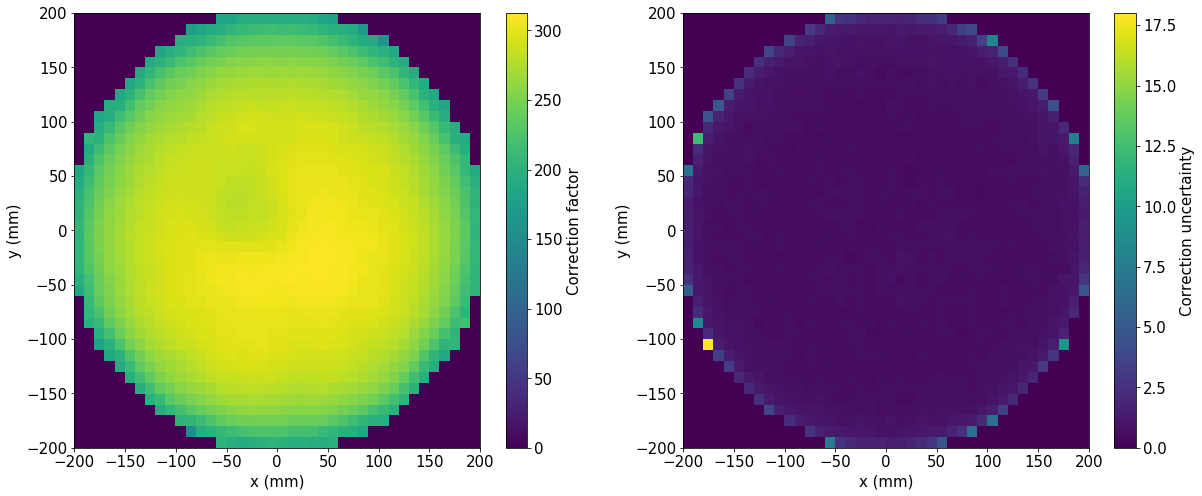

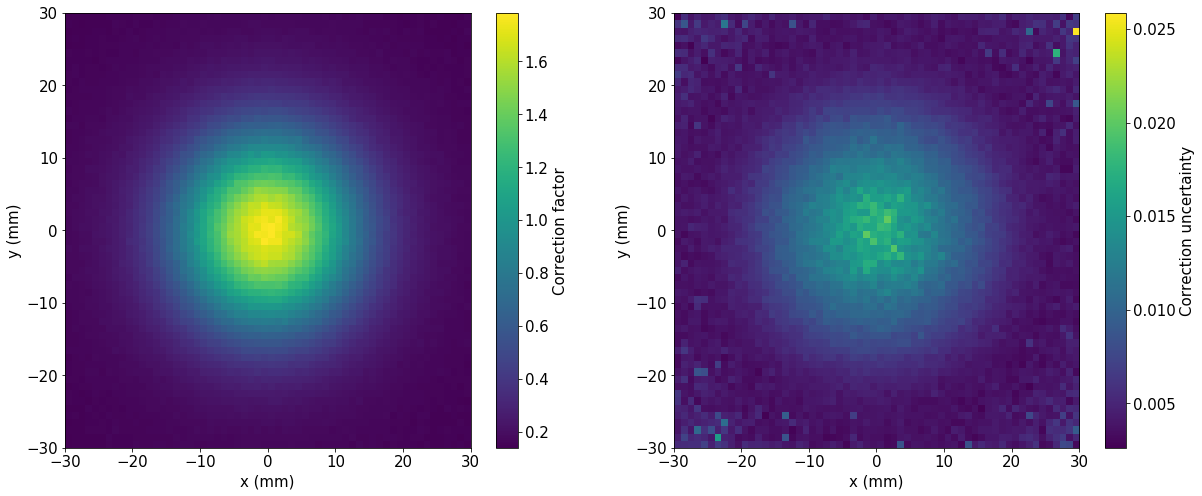

In [27]:
pmt_xy_map = []
sipm_xy_map = []
modePMT = "Sum"
nPMT = 11
pmt_sens = np.arange(0,nPMT,1)

pmtcorr = "/Users/ansimez/Documents/InvCit/hdf5/{}/PMT_Map_corr_keV".format(map_run_number)
sipmcorr = "/Users/ansimez/Documents/InvCit/hdf5/{}/SiPM_Map_corr_z".format(map_run_number)

zstep = 100
z_scan = np.arange(0.,600.,zstep)

for zmap in z_scan:
    sipmcorr_file = sipmcorr + "{}_keV.h5".format(zmap)
    sipm_xy_map.append(dstf.load_xy_corrections(sipmcorr_file, group="ResetMap", node="SiPM"))

if modePMT == "Sum":
    pmt_xy_map.append(dstf.load_xy_corrections(pmtcorr+".h5", group="ResetMap", node="PMT"))
elif modePMT == "Individual":
    for nsens in pmt_sens:
        pmtcorr_file = pmtcorr + "_{}.h5".format(nsens)
        pmt_xy_map.append(dstf.load_xy_corrections(pmtcorr_file, group="ResetMap", node="PMT"))
#        pmt_xy_map.append(dstf.load_xy_corrections(pmtcorr_file+".h5"))
else:
    print("Invalid mode")
    
    
plot_map(pmt_xy_map[0])    
plot_map(sipm_xy_map[3])

## Load event

In [28]:
h5out.close()   

NameError: name 'h5out' is not defined

In [121]:
slice_width = 2.

sipm_dist = 20.
point_dist = 20.
sizeX = 2.
sizeY = 2.
sipm_thr = 5.
iterations = 100
fCathode = True
fAnode = True
e_thres = 0.
verbose = False
verboseMLEM = False
rMax = 198
#zstep = 100
#modePMT = "Individual"
#nPMT = 11

outputfolder = "/Users/ansimez/Documents/InvCit/hdf5/{}/reset_dst/".format(run_number)
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)
    
in_limit = 189
filestep = 1
s2pmt_file = {}

for fnumber, file in enumerate(inputfiles[in_limit:in_limit+filestep]):
    outputfile = outputfolder + "reset_dst_"+modePMT+"_{}_select.h5".format(fnumber+in_limit)
    h5out = tb.open_file(outputfile, 'w')
    dst_table = tbiof.make_table(h5out, 
                            group = "Reset_DST",
                            name = "Reset voxels",
                            fformat = ResetDST,
                            description = 'Reset voxels',
                            compression = "ZLIB4")
    row = dst_table.row 
    print("Running on ", time.asctime())
    try: 
#        s1_file, s2_file, s2si_file, _, s2pmt_file = pmapio.load_pmaps_with_ipmt(file)
        s1_file, s2_file, s2si_file, = pmapio.load_pmaps(file)
    except: 
        print("File {} could not be opened".format(file))
    else:
        common_events = set(s1_file.keys()) & set(s2_file.keys()) & set(s2si_file.keys())
        s1_all = dict({k:v for k,v in s1_file.items() if k in common_events})
        s2_all = dict({k:v for k,v in s2_file.items() if k in common_events})
        s2si_all =  dict({k:v for k,v in s2si_file.items() if k in common_events})
        s2pmt_all = dict({k:v for k,v in s2pmt_file.items() if k in common_events})
        
        select = refresh_selector(init_val)

#        for evt in range(1,2):
        for evt in s1_all:
            if(evt != 21215):
                continue
            else:
                print("file: {}".format(fnumber))
            if(verbose):
                print("Filter")
                %timeit(s1s2filt.s1s2_filter(select, s1_all[evt], s2_all[evt], s2si_all[evt]))

            if not s1s2filt.s1s2_filter(select, s1_all[evt], s2_all[evt], s2si_all[evt]):
                continue
            s1_cut = select.select_valid_peaks(s1_all[evt], select.s1_ethr, select.s1e, select.s1w, select.s1h)
            s2_cut = select.select_valid_peaks(s2_all[evt], select.s2_ethr, select.s2e, select.s2w, select.s2h)
            s2si_cut = select.select_s2si(s2si_all[evt], select.nsi)
    
            if(verbose):
                print("select_valid_peaks")
                %timeit(select.select_valid_peaks(s1_all[evt], select.s1_ethr, select.s1e, select.s1w, select.s1h))
                %timeit(select.select_valid_peaks(s2_all[evt], select.s2_ethr, select.s2e, select.s2w, select.s2h))
                %timeit(select.select_s2si(s2si_all[evt], select.nsi))
            
            s1 = s1_all[evt].peak_waveform(0)
            t0 = s1.t[np.argmax(s1.E)]

            s2_cut = [peakno for peakno, v in s2_cut.items() if v == True]
            s2si_cut = [peakno for peakno, v in s2si_cut.items() if v == True]
            
            valid_peaks = set(s2_cut) & set(s2si_cut)

            for no in valid_peaks:
                s2 = s2si_all[evt].s2d[no]
                s2si = s2si_all[evt].s2sid[no]
                if modePMT == "Individual":
                    s2pmt = []
                    for nsens in pmt_sens:
                        s2pmt.append(rebin_s2pmt(s2pmt_all[evt].pmt_waveform(no, nsens), slice_width))
                s2, s2si = rebin_s2si(s2, s2si, slice_width)
                if(verbose):
                    print("Rebin")
                    %timeit(rebin_s2si(s2, s2si, slice_width))
                    
                for tbin, e in enumerate(s2[1]):
                    slice_ = pmapsfc.sipm_ids_and_charges_in_slice(s2si, tbin)
                    if len(slice_[0]) <= 0:
                        continue
                    if(verbose):
                        print("Charges in slice")
                        %timeit(pmapsfc.sipm_ids_and_charges_in_slice(s2si, tbin))
                    z = (np.average(s2[0][tbin], weights=s2[1][tbin]) - t0)/1000.
                    if(z>550):
                        continue
                    if(verbose):
                        print("Z calc")
                        %timeit((np.average(s2[0][tbin], weights=s2[1][tbin]) - t0)/1000.)
                    #Create voxels
                    sens_q = np.array(slice_[1]*ZCorr(z).value)
                    if len(sens_q[sens_q>sipm_thr]) <= 0:
                        continue     
                    
                    vox = rstf.CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY, rMax)
#                    voxOld = rstfOld.CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY, rMax)
                    if len(vox[0]) <= 0:
                        continue
                    if(verbose):
                        print("Create vox")
                        %timeit(rstf.CreateVoxels(DataSiPM, np.array(slice_[0]), sens_q, point_dist, sipm_thr, sizeX, sizeY))
                    #Create anode and cathode response 
                    anode_response = rstf.CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, vox)
#                    anode_responseOld = rstfOld.CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, voxOld)

                    if modePMT == "Sum":
                        cath_response = np.array([e*ZCorr(z).value])
                    elif modePMT == "Individual":
                        cath_response = []
                        for nsens in pmt_sens:
                            cath_response.append(s2pmt[nsens][1][tbin]*ZCorr(z).value)
                    else:
                        print("Invalid mode")
                    
                    if(verbose):
                        print("Anode and cath response")
                        %timeit(rstf.CreateSiPMresponse(DataSiPM, np.array(slice_[0]), sens_q, sipm_dist, sipm_thr, vox))
                        %timeit(np.array([e*ZCorr(z).value]))
                    
                    #Run MLEM
                    imageIter = vox
#                    imageIterOld = voxOld
#                    imageIter2 = vox
                    voxDX, voxDY = rstf.computeDiff(DataSiPM, vox, anode_response)
#                    voxDXOld, voxDYOld = rstfOld.computeDiff(DataSiPM, voxOld, anode_responseOld)
#                    selVoxOld, selSensOld = rstfOld.createSel(voxDXOld, voxDYOld, anode_responseOld, sipm_dist)
                    selVox, selSens = rstf.createSel(voxDX, voxDY, anode_response, sipm_dist)
                    if(verbose):
                        print("voxD and sel and prob")
                        %timeit(rstf.computeDiff(DataSiPM, vox, anode_response))
                        %timeit(rstf.createSel(voxDX, voxDY, anode_response, sipm_dist))
                        %timeit(rstf.computeProb(pmt_xy_map, sipm_xy_map, voxDX, voxDY, vox[0], vox[1]))
#                    print("Slice ini at ", time.asctime())
                    z_index = int(z//zstep )
#                    print(z)
#                    print(z_index)
                    sipm_prob, pmt_prob = rstf.computeProb(pmt_xy_map, sipm_xy_map[z_index], voxDX, voxDY, vox[0], vox[1])
#                    sipm_probOld, pmt_probOld = rstfOld.computeProb(pmt_xy_map, sipm_xy_map[z_index], voxDXOld, voxDYOld, voxOld[0], voxOld[1])

                    j = 0
                    for j in range(iterations):
                        if(verboseMLEM):
                            print("MLEM_step")
                            %timeit rstf.MLEM_step(voxDX, voxDY, imageIter, selVox, selSens, anode_response, cath_response, pmt_prob, sipm_prob, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)
                            print("AnodeForward")
                            %timeit(rstf.ComputeAnodeForward(voxDX, voxDY, imageIter, anode_response, sipm_dist, sipm_prob, selVox))
                            print("CathodeForward")
                            %timeit(rstf.ComputeCathForward(vox, cath_response, pmt_prob))
#                        imageIter = rstf.MLEM_step(voxDX, voxDY, imageIter, anode_response, cath_response, pmt_xy_map, sipm_xy_map, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)    
#                        anode_forward = rstf.ComputeAnodeForward(voxDX, voxDY, imageIter, anode_response, sipm_dist, sipm_prob, selVox)
#                        cath_forward = rstf.ComputeCathForward(vox, cath_response, pmt_prob)
#                        anode_forwardOld = rstfOld.ComputeAnodeForward2(voxDXOld, voxDYOld, imageIterOld, anode_responseOld, sipm_dist, sipm_probOld, selVoxOld)
#                        cath_forwardOld = rstfOld.ComputeCathForward2(voxOld, cath_response, pmt_probOld)
                        imageIter = rstf.MLEM_step(voxDX, voxDY, imageIter, selVox, selSens, anode_response, cath_response, pmt_prob, sipm_prob, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)  
#                        imageIterOld = rstfOld.MLEM_step2(voxDXOld, voxDYOld, imageIterOld, selVoxOld, selSensOld, anode_responseOld, cath_response, pmt_probOld, sipm_probOld, sipm_dist=sipm_dist, eThres=e_thres, fCathode = fCathode, fAnode = fAnode)  
                        
#                        for iv in range(len(imageIter[0])):
#                            if imageIter[2][iv] <= 0.00001:
#                                continue
#                            row['X'] = imageIter[0][iv]
#                            row['Y'] = imageIter[1][iv]
#                            row['Z'] = z
#                            row['E'] = imageIter[2][iv]
#                            row['PeakNo'] = no
#                            row['EventID'] = evt
#                            row['Iteration'] = j+1
#                            row.append() 
                        
    #Save Event
                    for iv in range(len(imageIter[0])):
                        if imageIter[2][iv] <= 0.1:
                            continue
                        row['X'] = imageIter[0][iv]
                        row['Y'] = imageIter[1][iv]
                        row['Z'] = z
                        row['E'] = imageIter[2][iv]
                        row['PeakNo'] = no
                        row['EventID'] = evt
                        row['Iteration'] = j+1
                        row.append() 
    h5out.close()                    


Running on  Mon Nov  6 13:07:34 2017
file: 0


In [122]:
outputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/4495/reset_dst/" + "reset_dst_*Sum*elect*")
#outputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/4670/reset_dst/" + "reset_dst_keV_thesis*")
info = dstio.load_dsts(outputfiles, "Reset_DST", "Reset voxels")
info#[info.EventID==100000]

,X,Y,Z,E,EventID,PeakNo,Iteration
0,141.0,51.0,421.652812,0.100113,21215.0,0.0,100.0
1,141.0,53.0,421.652812,0.117854,21215.0,0.0,100.0
2,143.0,53.0,421.652812,0.133689,21215.0,0.0,100.0
3,143.0,57.0,421.652812,0.102372,21215.0,0.0,100.0
4,135.0,55.0,423.737500,0.103023,21215.0,0.0,100.0
5,137.0,49.0,423.737500,0.101294,21215.0,0.0,100.0
6,137.0,55.0,423.737500,0.212167,21215.0,0.0,100.0
7,139.0,49.0,423.737500,0.105716,21215.0,0.0,100.0
8,139.0,51.0,423.737500,0.116111,21215.0,0.0,100.0
9,139.0,53.0,423.737500,0.110810,21215.0,0.0,100.0


21215


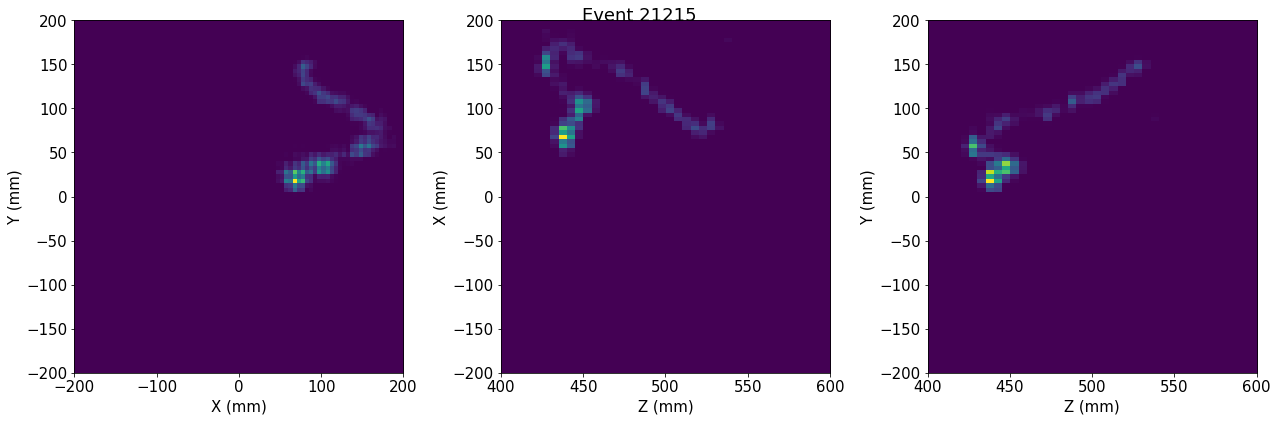

In [123]:
evt = 16
size = 5
binsZ = 200/size
binsX = 400/size

#list_evt = [1305, 2705, 4794, 8971, 16258, 23079, 37314, 39704, 40298, 40792, 48673, 54120, 64600, 68323, 77021, 81923, 85794, 89346, 92275]


#for evt in range(0, 110000):
for evt in [21215]:
    if (info[info.EventID==evt].Z.mean() > 0) & (info[info.EventID==evt].E.sum() > 0) & ( (info[info.EventID==evt].Z.max() - info[info.EventID==evt].Z.min()) > 0) :
#    if (info[info.EventID==evt].Z.mean() > 450) & (info[info.EventID==evt].E.sum() > 1200) & ( (info[info.EventID==evt].Z.max() - info[info.EventID==evt].Z.min()) > 100) :
        print(evt)
        fig, axes = plt.subplots(1, 3, figsize=(18,6))
        fig.suptitle("Event {}".format(evt))
        plt.sca(axes[0])
        _ = hist2d(info[info.EventID==evt].X, info[info.EventID==evt].Y, [binsX, binsX], [[-200.,200.],[-200.,200.]], weights= info[info.EventID==evt].E, new_figure=False)
        labels("X (mm)", "Y (mm)", "")

        plt.sca(axes[1])
        _ = hist2d(info[info.EventID==evt].Z, info[info.EventID==evt].X, [binsZ, binsX], [[400.,600.],[-200.,200.]], weights= info[info.EventID==evt].E, new_figure=False)
        labels("Z (mm)", "X (mm)", "")
        
        plt.sca(axes[2])
        _ = hist2d(info[info.EventID==evt].Z, info[info.EventID==evt].Y, [binsZ, binsX], [[400.,600.],[-200.,200.]], weights= info[info.EventID==evt].E, new_figure=False)
        labels("Z (mm)", "Y (mm)", "")

        fig.tight_layout()
        
        

In [ ]:
print("vox = {}".format(np.allclose(vox, voxOld)))
print("anode_response = {}".format(np.allclose(anode_response, anode_responseOld)))
print("sipm_probOld = {}".format(np.allclose(sipm_prob, sipm_probOld)))
print("pmt_probOld = {}".format(np.allclose(pmt_prob, pmt_probOld)))
print("anode_forward = {}".format(np.allclose(anode_forward, anode_forwardOld)))
print("cath_forward = {}".format(np.allclose(cath_forward, cath_forwardOld)))
print("imageIterOld = {}".format(np.allclose(imageIter, imageIterOld)))
#print("vox = {}".format(np.allclose(vox, voxOld)))

In [34]:
evt_id = list(set(info.EventID))

e = []
x = []
y = []
z = []
evid = []
n = 0
for ID in evt_id:    
#    print(n)
    dst = info[info.EventID == ID]
    xye = [[[dst.iloc[i].X, dst.iloc[i].Y], dst.iloc[i].E] for i in range(len(dst))]
    clust = xyf.barycenter([element[0] for element in xye], [element[1] for element in xye])
    
    x.append(clust[0].X)
    y.append(clust[0].Y)
    z.append(info[info.EventID == ID].Z.mean())
    e.append(clust[0].Q)
    evid.append(ID)
#    n+=1
    
x = np.array(x)
y = np.array(y)
z = np.array(z)
e = np.array(e)
evid = np.array(evid)

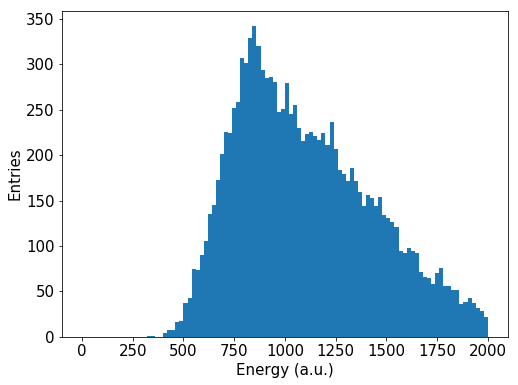

In [37]:
r = np.sqrt(x*x+y*y)
sel = r<100
#sel = sel & (z<200)

yf, xf, _ = hist(e[sel], 100, [0,2000])
labels("Energy (a.u.)", "Entries")
#seed = (yf.max(), xf.mean(), xf.std())
#f    = fitf.fit(fitf.gauss, xf, yf, seed, fit_range=(38.,45.))
#plt.plot(xf, f.fn(xf), fitOpt)
#plt.text(20., 1200, gausstext(f.values, f.errors, 41.5))


In [19]:
evt_id = list(set(info.EventID))

e = []
x = []
y = []
z = []
evid = []
n = 0
for ID in evt_id:    
#    print(n)
    dst = info[info.EventID == ID]
    xye = [[[dst.iloc[i].X, dst.iloc[i].Y], dst.iloc[i].E] for i in range(len(dst))]
    clust = xyf.barycenter([element[0] for element in xye], [element[1] for element in xye])
    
    x.append(clust[0].X)
    y.append(clust[0].Y)
    z.append(info[info.EventID == ID].Z.mean())
    e.append(clust[0].Q)
    evid.append(ID)
#    n+=1
    
x = np.array(x)
y = np.array(y)
z = np.array(z)
e = np.array(e)
evid = np.array(evid)

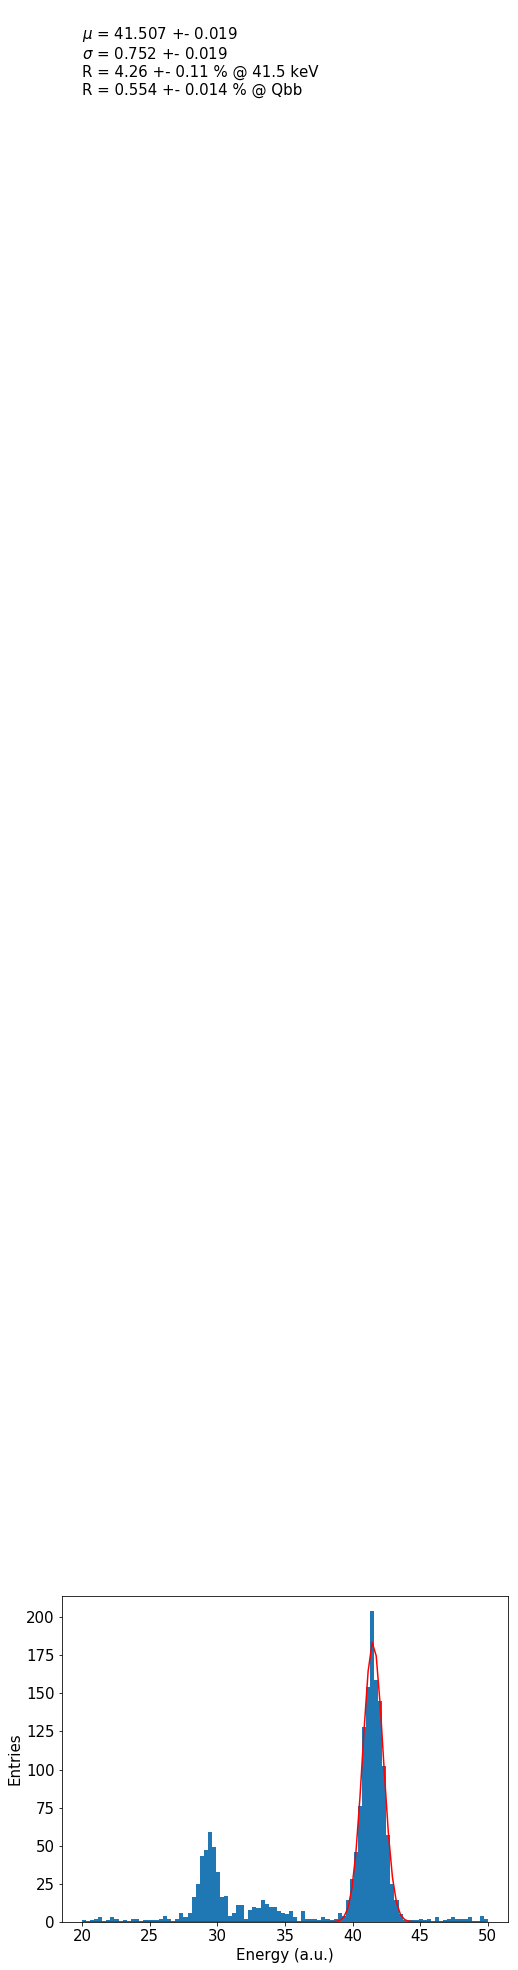

In [20]:
r = np.sqrt(x*x+y*y)
sel = r<150
sel = sel & (z<200)

yf, xf, _ = hist(e[sel], 100, [20,50])
labels("Energy (a.u.)", "Entries")
seed = (yf.max(), xf.mean(), xf.std())
f    = fitf.fit(fitf.gauss, xf, yf, seed, fit_range=(38.,45.))
plt.plot(xf, f.fn(xf), fitOpt)
plt.text(20., 1200, gausstext(f.values, f.errors, 41.5))


In [ ]:
r = np.sqrt(x*x+y*y)
reso = []
resoE = []
resoQ = []
resoQE = []

for rlimit in np.arange(50., 210., 10.):
    sel = r<rlimit
    yf, xf, _ = hist(e[sel], 100, [20,50])
    labels("Energy (a.u.)", "Entries")

    seed = (yf.max(), xf.mean(), xf.std())
    f    = fitf.fit(fitf.gauss, xf, yf, seed, fit_range=(38.,45.))
    plt.plot(xf, f.fn(xf), fitOpt)
    res = f.values[2]*235/f.values[1]
    resE = np.sqrt((f.errors[2]*235/f.values[1])**2 + (f.values[2]*235*f.errors[1]/(f.values[1]**2))**2)
    reso.append(res)
    resoE.append(resE)
    resoQ.append(res*np.sqrt(41.5/2458.))
    resoQE.append(resE*np.sqrt(41.5/2458.))
    plt.text(20., 1200, gausstext(f.values, f.errors, 41.5))
    
figRes, axRes = plt.subplots()

rrange = np.arange(50., 210., 10.)

axRes.errorbar(rrange, reso, yerr=resoE, linestyle="None", color='blue', marker='o')
axResQbb = axRes.twinx()  
axResQbb.errorbar(rrange, resoQ, yerr=resoQE, linestyle="None", color='blue', marker='o')
typeaxis = 'Fiducial radius (mm)'
axRes.set_xlabel(typeaxis, fontsize=16)
axRes.set_ylabel('Energy resolution (%)', fontsize=16)
axResQbb.set_ylabel(r'Energy resolution at Q$_{\beta\beta}$ (%)', fontsize=16)
axRes.set_ylim(5., 6.)

    
    #plt.text(25., 1250, gausstext(f.values, f.errors, 41.5))
#plt.text(25., 1250, "hola")
#reso = []
#resoE = []
#resoQ = []
#eresoQE = []
#print(f.values)
'''
plt.figure()
plt.scatter(z,e, s=5, alpha=0.5)
plt.xlim(0,500)
plt.ylim(80000,120000)
labels("Z (mm)", "Energy (a.u.)", "Energy vs Z")

hist2d(x,y, 40, [[-200., 200.],[-200.,200.]])
labels("X (mm)", "Y (mm)", "XY position")

(xc, yc, Ec, Ece), _, cb = \
hist2d_profile(x, y, e, 40, 40, [-200., 200.], [-200., 200.])
cb.set_label("E (au)")
labels("X (mm)", "Y (mm)", "Energy vs XY")

hist2d(z[sel], e[sel], 100, [[0, 600],[20, 50]])
labels("Z (mm)", "Energy (a.u.)", "Energy vs Z")

hist2d(r[sel], e[sel], 100, [[0, 200],[20, 50]])
labels("R (mm)", "Energy (a.u.)", "Energy vs R")'''


In [ ]:
figRes, axRes = plt.subplots()

rrange = np.arange(50., 210., 10.)

axRes.errorbar(rrange, reso, yerr=resoE, linestyle="None", color='blue', marker='o')
axResQbb = axRes.twinx()  
axResQbb.errorbar(rrange, resoQ, yerr=resoQE, linestyle="None", color='blue', marker='o')
typeaxis = 'Fiducial radius (mm)'
axRes.set_xlabel(typeaxis, fontsize=16)
axRes.set_ylabel('Energy resolution (%)', fontsize=16)
axResQbb.set_ylabel(r'Energy resolution at Q$_{\beta\beta}$ (%)', fontsize=16)
axRes.set_ylim(4.5, 7.)
axResQbb.set_ylim(4.5*np.sqrt(41.5/2458.), 7.*np.sqrt(41.5/2458.))

In [ ]:
resE = np.sqrt((f.errors[2]*235/f.values[1])**2 + (f.values[2]*235*f.errors[1]/(f.values[1]**2))**2)
resE

In [ ]:
f.errors[1]

In [ ]:
#evt_id

In [ ]:
xrange = [-200,200]
yrange = [-200,200]

dst = info[info.EventID == evt_id[17]]

i = 10
_ = hist2d(dst.X,dst.Y, [(xrange[1]-xrange[0])/sizeX, (yrange[1]-yrange[0])/sizeY], [xrange,yrange], weights = dst.E)